# Adaptive PDE discretizations on cartesian grids
## Volume : Non-divergence form PDEs
## Part : Application examples
## Chapter : Boat routing, with sampled data

In this notebook, we compute the optimal route for a boat under assumptions very similar to this [previous notebook](../BoatRouting_Time.ipynb). The difference lies in the representation of the cost function: instead of a quadratic cost, we use data samples provided to us by MaxSea, showing the fuel consumption of the boat depending on its speed and the meteorological conditions.

The fuel consumption $C(t,x)$ of the boat, needed to reach a point $x$ at time $t$, obeys the Hamilton-Jacobi-Bellman PDE
$$
    \partial_t C(t,x) + \sup_v \Big( <\nabla_x C(t,x),v> - c(t,x,v)\Big) = 0.
$$
We consider only a finite set of admissible velocities $(v_i)_{i=1}^I$. The corresponding cost $c(t,x,v_i)$ is interpolated from the dataset, depending on the meteorological conditions at time $t$ and position $x$.

The numerical techniques used in this notebook rather classical, almost a textbook example. In particular they do not involve Selling's tensor decomposition, or related lattice basis reduction tools, which play a central role in the other notebooks of this repository.

[**Summary**](Summary.ipynb) of volume Non-Divergence form PDEs, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. The numerical scheme](#1.-The-numerical-scheme)
    * [1.1 Decomposition of the velocities](#1.1-Decomposition-of-the-velocities)
    * [1.2 Interpolation of the costs](#1.2-Interpolation-of-the-costs)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries.

In [1]:
import sys; sys.path.insert(0,"../..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('BoatRouting2_Time','NonDiv'))

In [2]:
from agd import AutomaticDifferentiation as ad
from agd import LinearParallel as lp
from agd import FiniteDifferences as fd
from agd.Interpolation import UniformGridInterpolation as interp
from agd.ODE.backtrack import RecurseRewind,odeint_array
from agd.Plotting import quiver
norm = ad.Optimization.norm

In [3]:
import numpy as np; xp=np; allclose=np.allclose
from matplotlib import pyplot as plt
from scipy.interpolate import RegularGridInterpolator

Utilities

In [4]:
# Equivalently, with Python >= 3.8, from itertools import accumulate
from agd.ExportedCode.Notebooks_NonDiv.Time1D_NonDiv import accumulate 

In [5]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global RecurseRewind,odeint_array
    RecurseRewind,odeint_array = rreload([RecurseRewind,odeint_array],rootdir="../..")

### 0.1 Optional configuration

Uncomment the following line to use GPU acceleration

In [6]:
xp,plt,allclose,quiver = map(ad.cupy_friendly,(xp,plt,allclose,quiver))

Replacing numpy with cupy, set to output 32bit ints and floats by default.
Using cp.asarray(*,dtype=np.float32) as the default caster in ad.array.
Returning a copy of module matplotlib.pyplot whose functions accept cupy arrays as input.
Setting float32 compatible default values atol=rtol=1e-5 in np.allclose
Returning a copy of function quiver which accepts cupy arrays as input.


Choose between small or large instances using the following line. Computation time may become a bit longer.

In [126]:
large_instances = xp is not np # By default : large instances on GPU, small on CPU

## 1. The numerical scheme

The numerical scheme for time dependent HJB PDE of interest reads
$$
    \frac {u(t+\delta t,x) - u(t,x)} {\delta t} 
    {+} \max_{1 \leq i \leq I} \Big( \sum_{1 \leq j \leq d}  \alpha_{ij} \frac {u(t,x)-u(t,x-h e_{ij})} h - c(t,x,v_i) \Big)= 0.
$$
This is a first order scheme, in time and space, relying on a decomposition of the velocities of the form
$$
    v_i = \sum_{1 \leq j \leq d} \alpha_{ij} e_{ij},
$$
where $\alpha_{ij} \geq 0$, and $e_{ij}$ has integer coordinates. 
The vectors $e_{ij} \in Z^2$ are chosen adaptively, among a four point or an eight point neighborhood.

The scheme is monotone, subject to the CFL condition 
$$
\delta t \max_i \sum_j \alpha_{ij} \leq h.
$$
For the four point stencil, one can simplify the condition into $\delta t \sqrt 2  \leq h$, and for the eight point stencil into $\delta t   \leq h$.
Higher order schemes are expected to lack the monotony property, and hence also the associated robustness properties.

### 1.1 Decomposition of the velocities

We use upwind finite differences on a four point or an eight point stencil. (The latter is expected to be yield slight improvements in terms of numerical accuracy.)
For that purpose, the vectors must be decomposed, in the form
$$
    v = \alpha_0 e_0 + \alpha_1 e_1,
$$
where $e_0,e_1 \in \{-1,0,1\}^2$, and where $\alpha_0,\alpha_1 \geq 0$.

In [7]:
def decomp(v,four_point=False):
    v = ad.asarray(v)
    # Decomposition over the four point stencil
    shape = v.shape[1:]
    α = np.abs(v)
    e = (np.sign(v) * fd.as_field(xp.eye(2),shape,depth=2)).astype(int)
    if four_point: return α,e
    
    # Decomposition over the eight point stencil
    pos = α[0]<α[1]
    α[1][pos] -= α[0][pos]
    e[:,0][:,pos] += e[:,1][:,pos]
    
    pos = np.logical_not(pos)
    α[0][pos] -= α[1][pos]
    e[:,1][:,pos] += e[:,0][:,pos]
    return α,e

Let us check our decomposition.

In [8]:
θ = xp.linspace(0,2.*np.pi,endpoint=False)
v = ad.array([np.cos(θ),np.sin(θ)])
α,e = decomp(v)

assert np.all(α>=0) # Non-negative weights 
assert np.allclose(v,(α*e).sum(axis=1)) # Reconstruction

### 1.2 Finite difference scheme

The HJB PDE of interest involves a maximum of linear functions, obtained in the next scheme.

In [9]:
def Scheme0(u,dx,velocity,costs,four_point=False):
    """Computes <du,velocity> - costs"""
    velocity,costs=[fd.as_field(e,u.shape) for e in (velocity,costs)]
    α,e = decomp(velocity,four_point=four_point)
    du = fd.DiffUpwind(u,-e,dx) # (u(x-he)-u(x))/h
    return lp.dot_VV(α,-du) - costs 

In [10]:
def Scheme(u,dt,scheme0):
    """One explicit step of the discretized HJB PDE, from the output of scheme0"""
    return u-dt*np.nanmax(scheme0,axis=(0,1))

The scheme is monotone provided the following CFL condition is satisfied
$$
    \|v\|\, \delta t \leq \delta x,
$$
for all considered velocities.

In [11]:
def CFL(velocity,h,four_point=False):
    """Largest time_step for which the scheme is stable."""
    α,_ = decomp(velocity,four_point)
    return dx/np.max(np.sum(α,axis=0))

We wish to use exact penalization, and for that purpose, the initial condition will be initialized in the form 
$$
    u_0(x) = K \|x\|
$$
if the source point is at the origin, where $K$ is sufficiently large. In contrast with the quadratic scheme however, the CFL condition is independent of the Lipschitz constant $K$.

### 1.3 Optimization of the operator

We can improve computation time by saving the structure of the sparse linear operator involved in the definition of our numerical scheme.

<!---
#    op_ad.simplify_ad() # Surprisingly decreases efficiency (More random pattern of accesses ?)
#    return lambda u: op_ad.as_func(u.reshape(-1)) # Works but less efficient
--->

In [12]:
def MakeScheme0(u,dx,*args,**kwargs):
    """Save the sparse linear structure of Scheme0"""
    u_ad = ad.Sparse.identity(constant=np.zeros_like(u))
    op_ad = Scheme0(u_ad,dx,*args,**kwargs)
    lin = op_ad.tangent_operator()
    cst = op_ad.value
    return lambda u: (lin*u.reshape(-1)).reshape(cst.shape)+cst

## 2. Quadratic cost

For consistency checking, we reproduce a fully synthetic experiment, featuring a quadratic cost, in a square domain, not taking the sphere geometry into account. The fuel cost takes the form:
$$
    c(t,x,v) = \mu(t,x) + \frac 1 2 \|v-\omega(t,x)\|_{M(t,x)}^2.
$$

## 2.1 Setting


In [13]:
def quadratic_cost(model_params,velocity):
    μ, ω, M, velocity = fd.common_field( (*model_params,velocity),depths = (0,1,2,1))
    return μ + 0.5* lp.dot_VAV(velocity-ω,M,velocity-ω)

In [14]:
four_point=False

# Parameters : unit weight for time, unit horizontal drift, euclidean geometry
model_params = (1.,xp.array((1.,0.)),xp.eye(2)) # μ, ω, M
velocity = np.moveaxis(ad.array([[ (r*np.cos(θ),r*np.sin(θ)) for r in xp.linspace(1,0,8,endpoint=False)]
                     for θ in xp.linspace(0,2*np.pi,16,endpoint=False)]),-1,0)
cost = quadratic_cost(model_params,velocity) 
pde_params = velocity,cost

# Coordinate system
aX,dx = xp.linspace(-1,1,retstep=True)
X = ad.array(np.meshgrid(aX,aX,indexing='ij'))

# Initial condition
K_Lip = 5.
C_initial = K_Lip * norm(X,axis=0)
dt = CFL(velocity,dx)

# Time discretization
t_max = 1.5
dt = 0.5*CFL(velocity,dx,four_point)
t_range = np.arange(0,t_max,dt)

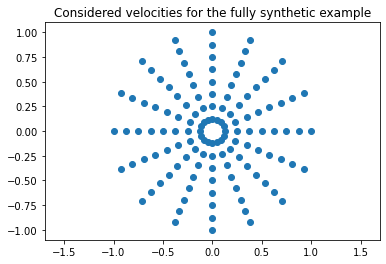

In [15]:
plt.title('Considered velocities for the fully synthetic example'); plt.axis('equal')
plt.scatter(*velocity);

In [16]:
PrecompScheme0 = MakeScheme0(C_initial,dx,*pde_params,four_point)
assert np.allclose(PrecompScheme0(C_initial),Scheme0(C_initial,dx,*pde_params,four_point),atol=3e-5,equal_nan=True)

In [17]:
#def advance(u,t=None): return Scheme(u,dt,Scheme0(u,dx,*pde_params,four_point)) # Non optimized
def advance(u,t=None): return Scheme(u,dt,PrecompScheme0(u)) # Optimized
C1 = advance(C_initial)
print(f"Smallest and largest value after one step : {np.min(C1)}, {np.max(C1)}")
assert np.min(C1)>=0 and np.isfinite(np.max(C1))

Smallest and largest value after one step : 0.16471566, 7.024274


In [18]:
%%time
C_solution = ad.array(list(accumulate(
    t_range[1:],
    initial=C_initial, 
    func=advance
)))

Wall time: 45.5 ms


Accuracy is only first order. Also, the polygonal nature of the approximation is clearly visible.

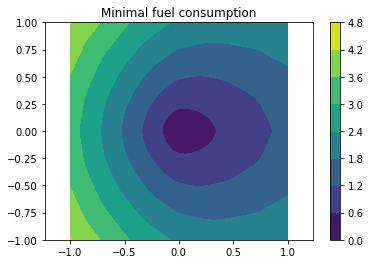

In [19]:
C_opt = np.min(C_solution,axis=0); 
plt.title("Minimal fuel consumption"); plt.axis('equal')
plt.contourf(*X,C_opt); plt.colorbar();

### 2.4 Computing the geodesic flow

Minimal paths are obtained by solving a time-dependent ODE, backwards from the final time to the initial time. As a first step, we must compute the optimal direction of the geodesics, which is obtained as the minimizer to the PDE of interest.

In [20]:
def BestVelocity(velocity,scheme0):
    shape = scheme0.shape[2:] # Domain shape
    scheme0 = scheme0.reshape((-1,*shape)) # flatten radius-angular dimension
    imax = np.nanargmax(scheme0,axis=0)

    velocity = velocity.reshape((2,-1)) # flatten radius-angular dimension
    velocity = fd.as_field(velocity,shape) # broadcast over domain

    return np.take_along_axis(velocity,imax.reshape((1,1)+imax.shape),axis=1).squeeze(axis=1) # Extract optimal

The best velocity, is radial, which is not unexpected : since our metric is constant in space and time the optimal geodesics are straight lines. Note however that the velocity takes discrete values, in contrast with the quadratic model studied in the previous notebook.

In [21]:
def get_velocity(u) : return BestVelocity(velocity,PrecompScheme0(u))

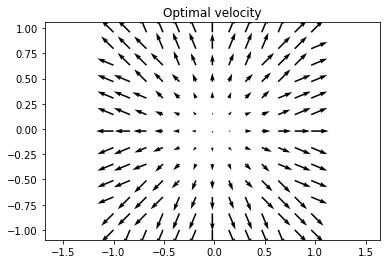

In [22]:
best_v = get_velocity(C_solution[50])
plt.title("Optimal velocity"); plt.axis('equal')
quiver(*X,*best_v,subsampling=(4,4))

Vehicles need to travel faster to reach points far from the origin. Note that the largest norm of a valid velocity is one, and that velocity norms take discrete values.

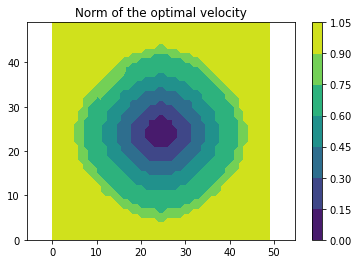

In [23]:
plt.title("Norm of the optimal velocity"); plt.axis('equal')
plt.contourf(norm(best_v,axis=0)); plt.colorbar();

 We observe here that the norms of the optimal velocity is a radial function. This may come as a surprise, since the fuel cost model is asymmetric. It is actually a property of the quadratic fuel cost, as discussed in the other notebooks.

### 2.5 Backtracking the geodesics

In [24]:
C_velocity = [get_velocity(C) for C in C_solution]
s=5; s0,s1 = X.shape[1:]
y0 = X[:,s0//(2*s)::s1//s,s0//(2*s)::s1//s].reshape((2,-1)) # Subsampled s x s grid used as initial points

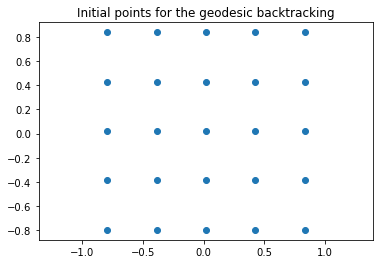

In [25]:
plt.title("Initial points for the geodesic backtracking"); plt.axis('equal')
plt.scatter(*y0);

We obtain *approximately* straight lines ending *approximately* at the origin, as was expected. Note that lines not ending at the origin are typically caused by either:
* Insufficient simulation time (diagnostic : the  minimal cost is attained for the final step)
* Insufficiently strong initial penalization.

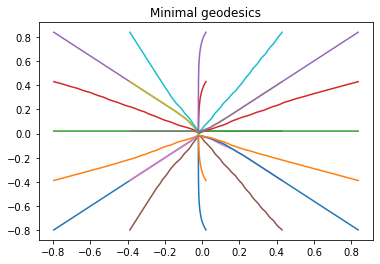

In [29]:
geodesics = odeint_array(C_velocity[::-1],y0,t_range[::-1],X)
plt.title("Minimal geodesics")
for geo in geodesics.T: plt.plot(*geo)

One may want to compute the geodesic not from the final time of the numerical simulation, but from the specific time. For instance, here, we select the time minimizing the travel cost. The results look similar to the above, because the metric is constant in time.

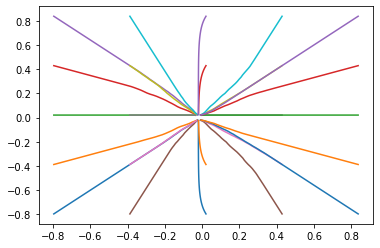

In [30]:
best_step = np.argmin(interp(X,C_solution)(y0),axis=0) # Step minimizing cost
t_delay = len(t_range) - best_step-1 # Account for reversed time
geodesics = odeint_array(C_velocity[::-1],y0,t_range[::-1],X, t_delay=t_delay)
for geo,delay in zip(geodesics.T,t_delay): plt.plot(*geo[:,delay:]) # Drop the first points according to delay

### 2.3 Optimization of memory usage

In practical applications, the number of iterations can be much larger than here, raising serious concerns about memory usage if all intermediate results are kept.

In [31]:
len(t_range)

74

A difficulty comes from the fact that the iterations need to be rolled back in order to backtrack the geodesics. For that purpose, a data structure is proposed that helds a selection of intermediate results (keypoints). We illustrate this mechanism here.

For $b^n$ iterations, $n b$ keypoints will be stored at most, where $b$ is the *basis* used in the keypoint scheme. By default $b=10$. At rewind time, the some values may be re-computed up to $n$ times.

In [32]:
C_generator = RecurseRewind(advance,C_initial)

# The generator applies advance recursively to C_initial
for C_ref,C in zip(C_solution,C_generator):
    assert np.allclose(C,C_ref)

# But there are fewer of them
print(f"Number of keypoints: {len(C_generator._keys)}, and indices: {C_generator._keys.keys()}")

# Only a few keypoints are stored, with the solution a the corresponding time
for key,value in C_generator._keys.items():
    assert np.allclose(value,C_solution[key])

# Rewind the iterations. This includes some recomputations, from suitable keypoints
C_generator.reversed = True
for value1,value2 in zip(C_generator,reversed(C_solution)):
    assert np.allclose(value1,value2)

Number of keypoints: 11, and indices: dict_keys([0, 10, 20, 30, 40, 50, 60, 70, 71, 72, 73])


In order to limit memory usage, one can use the keypoint based rewind mechanism, as follows.

<!---
def BestStep(iterator, y0, n):
    """Get the best step at y0, by advancing n times the iterator"""
    ny0=y0.shape[1]
    C_min = np.full(ny0,np.inf)
    iC_min= np.full(ny0,0)

    for i,C in zip(range(n),iterator):
        C_y0 = interp(X,C)(y0)
        pos = C_y0 < C_min
        C_min[pos] = C_y0[pos]
        iC_min[pos] = i
    return iC_min
--->

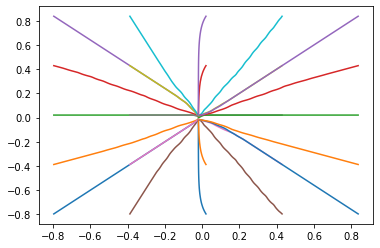

In [33]:
C_generator = RecurseRewind(advance,C_initial)
for t,C in zip(t_range,C_generator):
    # Do something with the PDE solution C at time t
    # Ex : compute the optimal step
    pass

C_generator.reversed=True
velocity_generator = (get_velocity(C) for C in C_generator) 
geodesics = odeint_array( velocity_generator ,y0,t_range[::-1],X)
for geo in geodesics.T: plt.plot(*geo)

## 3. Data driven cost

In this section, we run the algorithm with a set of costs and velocities that are closer to a real use case.
The set of velocities, is chosen in accordance with the provided data. In the local orthonormal frame these velocities read as follows.
A variant taking into account the earth geometry is proposed in the next section

In [127]:
velocity_norm = [5,7,8,9,10,12,14,16,18] # Boat velocity in knots
velocity_nangle = 48 if large_instances else 24
velocity_angle = xp.linspace(0,2*np.pi,velocity_nangle,endpoint=False)
velocity_flat = np.moveaxis(ad.array([ [(s*np.cos(θ),s*np.sin(θ)) for s in velocity_norm] for θ in velocity_angle]),-1,0)

### 3.2 Interpolation of the costs

We use a small subset of some example data that was provided to us by MaxSea. The costs are interpolated w.r.t. the meteorological conditions:
wind speed, wave period and height.

They correspond to a wind coming from the right, and are provided for a range of velocities and angles.
We do interpolate the costs w.r.t angle, but not velocity. The angular interpolation allows to use a fixed set of velocities, independent of the wind direction, thus greatly improves the numerical efficiency of the scheme.

<!---
conditions_all = {
    'True wind speed (kt)':[0, 5, 8, 10, 14, 18, 22, 26, 30, 35, 40],
    'Mean wave period (s)':[2, 4, 5.5, 7.5, 9, 10.5, 13, 16],
    'Significant wave height (m)':[0, 1.5, 3, 4.5, 6, 7.5, 10],
}
speed_entries = [5,7,8,9,10,12,14,16,18] # (knots ?) 
angle_entries = np.linspace(0,2*np.pi,25,endpoint=True)
--->

In [109]:
def MakeCosts():
    """Returns the an interpolation function for the costs, associated with the given conditions"""
    with open('ModelePerformanceNavire.npy','rb') as f:
        # cost axes are : angle, speed, wind speed, wave period, wave height
        costs = np.load(f)
    
    # Interpolation axes
    ax_boat_speed = [5,7,8,9,10,12,14,16,18] # Boat speed (knots ?) 
    ax_wind_angle = np.linspace(0,2*np.pi,25,endpoint=True) # Boat angle w.r.t wind
    ax_wind_speed = [0, 5, 8, 10, 14, 18, 22, 26, 30, 35, 40] # True wind speed (kt)
    ax_wave_period = [2, 4, 5.5, 7.5, 9, 10.5, 13, 16] # Mean wave period (s)
    ax_wave_height = [0, 1.5, 3, 4.5, 6, 7.5, 10] # Significant wave height (m)
    
    # Set angular variable in [0,2 pi] instead of [0,pi]
    costs = np.concatenate((costs, costs[:,-2::-1]),axis=1) 
    # Move boat_speed and wind_angle last, for convenience 
    costs = np.moveaxis(costs,(0,1),(-1,-2)) 

    # Interpolation on the CPU for now
    v_norm,v_angle = map(ad.cupy_generic.cupy_get,(velocity_norm,velocity_angle))
    costsI = RegularGridInterpolator((ax_wind_speed,ax_wave_period,ax_wave_height,ax_wind_angle), costs)
    assert np.allclose(v_norm,xp.array(ax_boat_speed)) # no interpolation needed on this axis
    
    def GetCosts(wind_angle,wind_speed,wave_period,wave_height):
        """Return the costs for all considered velocities of the boat, given the meteorological conditions"""
        # Add one dimension for sampling all the velocity angles
        wind_angle,wind_speed,wave_period,wave_height = (
            fd.as_field(e,shape=velocity_angle.shape,conditional=False) for e in (wind_angle,wind_speed,wave_period,wave_height))
        wind_rel_angle = (v_angle-wind_angle) % (2*np.pi) 

        pt = np.array((wind_speed,wave_period,wave_height,wind_rel_angle)).T
        extracted_costs = np.moveaxis(costsI(pt),-1,1) # velocity_angle,velocity_norm,...
        return xp.asarray(extracted_costs)
    
    return GetCosts

In [92]:
def show_displacement_cost(velocity,cost):
    """
    Polar plot of the distance reachable for unit fuel consumption,
    in all directions.
    """
    ratio = velocity/cost
    ratio = np.concatenate((ratio,ratio[:,:1]),axis=1)
    
    plt.title("Distance reached for unit fuel, at different boat speeds")
    plt.axis('equal')
    plt.plot(*ratio)
    plt.legend(velocity_norm)
    plt.scatter(0,0)

In [110]:
get_costs = MakeCosts()

In [111]:
help(get_costs)

Help on function GetCosts in module __main__:

GetCosts(wind_angle, wind_speed, wave_period, wave_height)
    Return the costs for all considered velocities of the boat, given the meteorological conditions



### 3.3 Discussion of the fuel consumption

The following polar plot presents the reachable distance per unit fuel for a boat, depending on the boat speed, in *flat weather conditions* and in particular *without wind or waves*. The following remarks are in order:
* The distance is independent of the boat direction, obviously, since there is no drag or drift due to the wind or waves.
* The maximal distance is not achieved for the minimal speed, or the maximal speed, but for something in between. This suggests that the boat fuel consumption at rest is not zero.

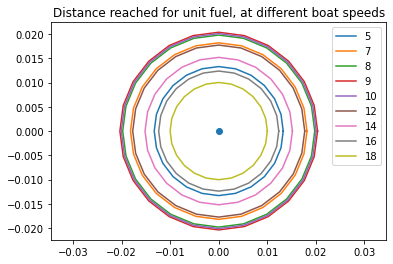

In [39]:
show_displacement_cost(velocity_flat,get_costs(0,0,4,0))

In the next plot, we introduce wind, in the direction $(1,0)$, horizontal and directed to the right. (? or is it the left ?)
The reachable distance now depends on the direction, in addition to the boat speed. 

A point of interest from the mathematical standpoint is that the set delimited by this distance is non-convex, for some boat speeds.
This property will not be reflected by the PDE solution, whose level set are expected to yield the convex envelope.

More complex models, involving additional state variables, are needed to properly reflect this behavior. Examples of additional state variables include:
* the orientation $\theta\in S^1$, suitably discretized for the numerical implementation.
* two states, corresponding to the side of the boat sail, with suitable transition costs.

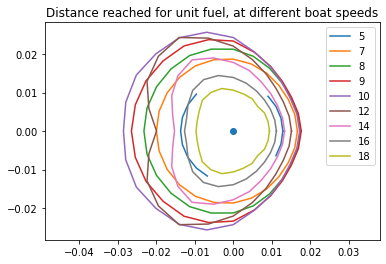

In [40]:
show_displacement_cost(velocity_flat,get_costs(0,14,4,1.5)) 

Fuel cost for a rotated wind.

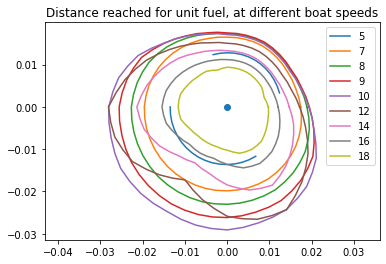

In [112]:
cost = get_costs(np.pi/3,14,4,1.5)
show_displacement_cost(velocity_flat,cost)

Some fuel costs are only partially known.

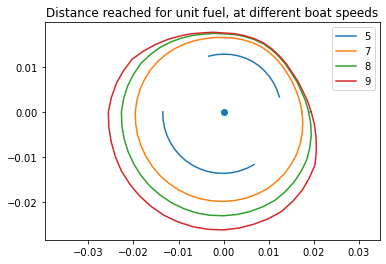

In [114]:
show_displacement_cost(velocity_flat[:,:,:4],cost[:,:4])

### 3.4 Numerical solution

We consider constant weather conditions, and reproduce the above curves from the PDE solution. 

In [115]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [128]:
# Coordinate system
aX,dx = xp.linspace(-1,1,100 if large_instances else 50,retstep=True)
X = ad.array(np.meshgrid(aX,aX,indexing='ij'))

four_point=True
pde_params = velocity_flat,cost

dt = 0.5*CFL(velocity_flat,dx,four_point)
t_max = 1./np.min(velocity_norm)
t_range = np.arange(0,t_max,dt)

C_initial = 300 * norm(X,axis=0) 

PrecompScheme0 = MakeScheme0(C_initial,dx,*pde_params,four_point)
def advance(u,t=None): return Scheme(u,dt,PrecompScheme0(u)) # Optimized

In the next cell, we compute the cost for all times $t \in [0,t_{\max}]$. We also extract the cost $C_s$ corresponding to a boat reaching position $x$ at time $t = s\| x\|$, where $s\in S$ belongs to the collection of speeds in our table.

The level lines $C_s = cst$ are expected to coincide, up to numerical precision, with the convex envelope boundary of the similar lines in the previous figure. This seems to be the case.

In [117]:
%%time
# Cost when moving at a constant velocity
C_cst_speed = [xp.full_like(C_initial,np.nan) for v in velocity_norm]

C_generator = RecurseRewind(advance,C_initial)
for t,C in zip(t_range,C_generator):
    for speed,C_speed in zip(velocity_norm,C_cst_speed):
        pos = np.abs(norm(X,axis=0)/speed - t) <= dt/0.49
        C_speed[pos] = C[pos]

Wall time: 5.56 s


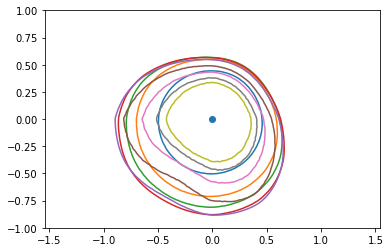

In [118]:
plt.scatter(0,0); plt.axis('equal')
for speed,C_speed,color in zip(velocity_norm,C_cst_speed,colors):
    plt.contour(*X,C_speed,levels=[40],colors=[color])

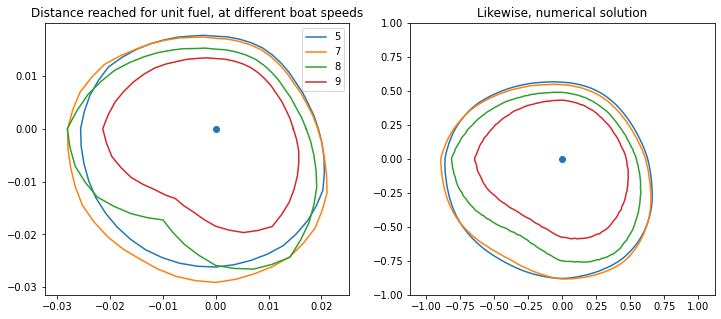

In [119]:
plt.figure(figsize=[12,5])
sl = slice(3,7)  # Selection of speeds to be shown

plt.subplot(1,2,1)
show_displacement_cost(velocity_flat[:,:,sl],cost[:,sl])

plt.subplot(1,2,2)
plt.title('Likewise, numerical solution')
plt.scatter(0,0); plt.axis('equal')
for speed,C_speed,color in zip(velocity_norm[sl],C_cst_speed[sl],colors):
    plt.contour(*X,C_speed,levels=[40],colors=[color])

## 4. Complex environment

We would want to take into account the geometry of the earth. For that purpose, the horizontal velocity needs to be rescaled depending on the latitude.

In [121]:

h = 1/100
longitudes = xp.arange(-0.5,0.5,h) # longitude in radians w.r.t Greenwitch 
latitudes  = xp.arange(-0.1,0.9,h) # Latitude in radians w.r.t Equator
X = ad.array(np.meshgrid(longitudes,latitudes,indexing='ij'))

velocity_sphere = ad.array(fd.as_field(velocity_flat,X.shape[1:]))
velocity_sphere[0] /= np.cos(X[1]) # Take into account map deformation
# TODO : one may introduce a scaling factor as well, since
# here the speed is in knots, and the earth radius is one...

α,e = decomp(velocity_sphere)

e.shape

(2, 2, 48, 9, 100, 100)